In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

In [11]:
from torchvision import models, transforms
from torchvision.models import VGG16_Weights
from torchvision.datasets import ImageFolder

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
def create_vgg16_model(num_classes=10, fine_tune=True):
    vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    if fine_tune:
        # Unfreeze all layers for fine-tuning
        for param in vgg16.parameters():
            param.requires_grad = True
    else:
        # Freeze all layers except the classifier
        for param in vgg16.parameters():
            param.requires_grad = False

    vgg16.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    return vgg16

In [14]:
vgg16_model = create_vgg16_model(num_classes=10, fine_tune=True)

# Define loss function, optimizer, and device
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

# Define different learning rates for pre-trained and newly added layers
params_to_update = [
    {"params": vgg16_model.features.parameters(), "lr": 1e-4},  # Lower learning rate for pre-trained layers
    {"params": vgg16_model.classifier.parameters(), "lr": 1e-3}  # Higher learning rate for the new classifier layers
]

optimizer = optim.Adam(params_to_update)

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [16]:
# Define data augmentation for the training set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(20),      # Randomly rotate images by up to 20 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly zoom in/out
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use simpler transforms for validation (no augmentation)
validate_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root='drive/MyDrive/inputs/train/', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

validate_dataset = ImageFolder(root='drive/MyDrive/inputs/validation/', transform=validate_transforms)
validation_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True, num_workers=2)

In [17]:
train_losses = []
train_accuracy = []

valid_loss = []
valid_accuracy = []

num_epochs = 32
for epoch in range(num_epochs):
    vgg16_model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += accuracy

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = running_accuracy / len(train_loader)

    train_losses.append(loss)
    train_accuracy.append(accuracy)

    # Validation phase
    vgg16_model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16_model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_valid_loss = running_loss / len(validation_loader)
    epoch_valid_accuracy = running_corrects.double() / total

    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy.item())

    print(f'Epoch {epoch+1}: ['
          f'Train Loss: [ {epoch_train_loss:.4f} ], Train Accuracy: [ {epoch_train_accuracy:.4f} ], '
          f'Valid Loss: [ {epoch_valid_loss:.4f} ], Valid Accuracy: [ {epoch_valid_accuracy:.4f} ]]')

    scheduler.step()

Epoch 1: [Train Loss: [ 0.8751 ], Train Accuracy: [ 0.7332 ], Valid Loss: [ 0.7687 ], Valid Accuracy: [ 0.7918 ]]
Epoch 2: [Train Loss: [ 0.4949 ], Train Accuracy: [ 0.8328 ], Valid Loss: [ 0.5033 ], Valid Accuracy: [ 0.8798 ]]
Epoch 3: [Train Loss: [ 0.4015 ], Train Accuracy: [ 0.8722 ], Valid Loss: [ 0.4025 ], Valid Accuracy: [ 0.8915 ]]
Epoch 4: [Train Loss: [ 0.3289 ], Train Accuracy: [ 0.8961 ], Valid Loss: [ 0.4447 ], Valid Accuracy: [ 0.8710 ]]
Epoch 5: [Train Loss: [ 0.3151 ], Train Accuracy: [ 0.8941 ], Valid Loss: [ 0.3266 ], Valid Accuracy: [ 0.8886 ]]
Epoch 6: [Train Loss: [ 0.2316 ], Train Accuracy: [ 0.9234 ], Valid Loss: [ 0.4491 ], Valid Accuracy: [ 0.8622 ]]
Epoch 7: [Train Loss: [ 0.2045 ], Train Accuracy: [ 0.9365 ], Valid Loss: [ 0.3955 ], Valid Accuracy: [ 0.8944 ]]
Epoch 8: [Train Loss: [ 0.1042 ], Train Accuracy: [ 0.9684 ], Valid Loss: [ 0.3449 ], Valid Accuracy: [ 0.9032 ]]
Epoch 9: [Train Loss: [ 0.0736 ], Train Accuracy: [ 0.9759 ], Valid Loss: [ 0.3523 ], Va

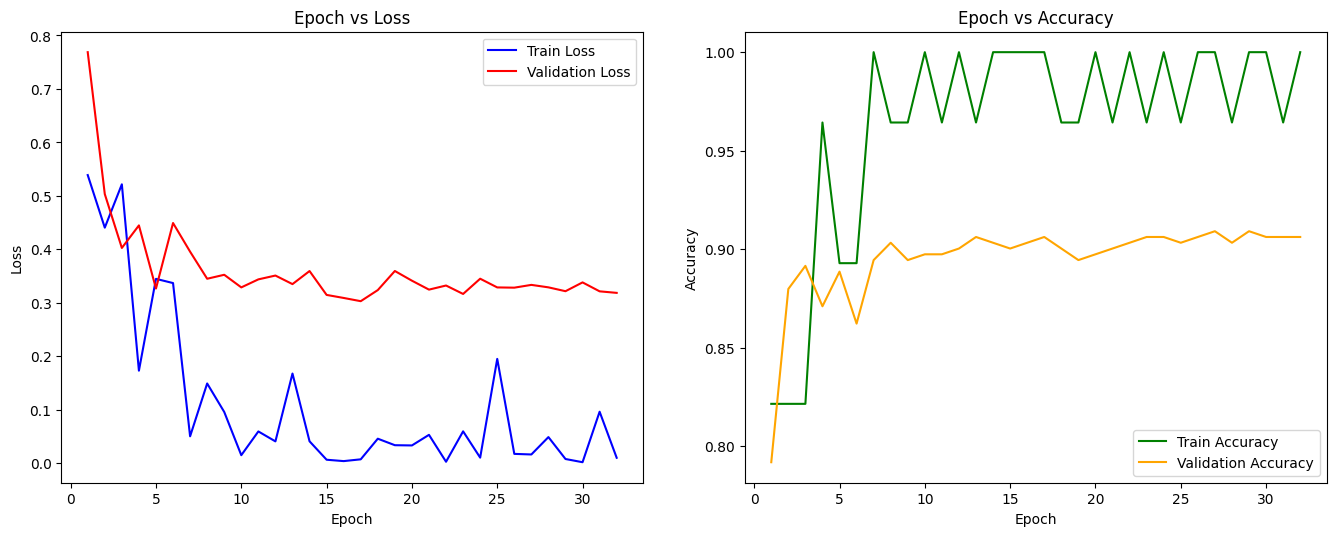

In [28]:
train_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
train_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy]

valid_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in valid_loss]
valid_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracy]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss, color='r', label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracy, color='orange', label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout(pad=3.0)
plt.show()

In [19]:
def get_clothing_item(number):
    clothing_items = {
        0: 'dress',
        1: 'hat',
        2: 'longsleeve',
        3: 'outwear',
        4: 'pants',
        5: 'shirt',
        6: 'shoes',
        7: 'shorts',
        8: 'skirt',
        9: 't-shirt'
    }

    return clothing_items.get(number, 'Unknown')

Predicted class: dress


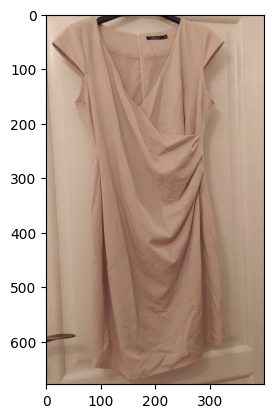

In [20]:
def predict_image(model, image_path, transform, device):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    image = transform(image)
    image = image.unsqueeze(0)

    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

image_path = 'drive/MyDrive/inputs/test/dress/35f157d0-53e4-4496-b087-da4ad63edd47.jpg'


predicted_class_index = predict_image(vgg16_model, image_path, train_transforms, device)
print(f'Predicted class: {get_clothing_item(predicted_class_index)}')

In [26]:
test_dataset = ImageFolder(root='drive/MyDrive/inputs/test', transform=validate_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

def evaluate_model(model, test_loader):
    model.eval()

    test_loss = 0.0
    test_accuracy = 0.0

    all_labels = []
    all_preds = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            accuracy = calculate_accuracy(outputs, labels)
            test_loss += loss.item()
            test_accuracy += accuracy

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)


    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

evaluate_model(vgg16_model, test_loader)

Test Loss: 0.2647, Test Accuracy: 0.9375
Precision: 0.9369, Recall: 0.9355, F1 Score: 0.9352
